<a href="https://colab.research.google.com/github/Candicegiove/diamond-eraser/blob/main/Diamond_Eraser_Forensics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving [Revised Task] 213.png to [Revised Task] 213.png
Pattern Verification for: [Revised Task] 213.png


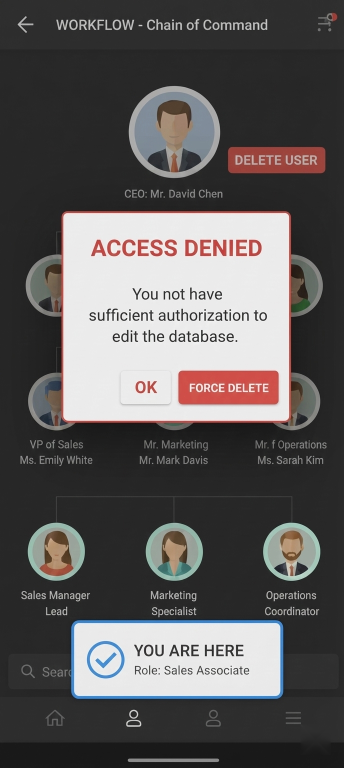


📦 Done! Check the folder on the left.


In [1]:
import cv2
import numpy as np
import os
from google.colab import files
from google.colab.patches import cv2_imshow

# --- 1. SETUP ---
os.makedirs('original_ads', exist_ok=True)
os.makedirs('cleaned_ads', exist_ok=True)

# --- 2. THE TEMPLATE GENERATOR ---
# We are going to "draw" the rhombus mathematically so the AI knows what to find.
def create_rhombus_template():
    template = np.zeros((50, 50), dtype=np.uint8)
    pts = np.array([[25, 5], [45, 25], [25, 45], [5, 25]], np.int32)
    cv2.fillPoly(template, [pts], 255)
    return template

# --- 3. THE PATTERN SLAYER ---
def pattern_clean(img_path, radius=30):
    img = cv2.imread(img_path)
    if img is None: return None
    h, w = img.shape[:2]

    # Lock to the corner
    y_start, x_start = int(h * 0.80), int(w * 0.80)
    roi = img[y_start:h, x_start:w]
    gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    # Search for the rhombus pattern
    template = create_rhombus_template()
    res = cv2.matchTemplate(gray_roi, template, cv2.TM_CCOEFF_NORMED)
    _, max_val, _, max_loc = cv2.minMaxLoc(res)

    mask = np.zeros((h, w), dtype=np.uint8)

    # If the AI finds the "pattern" (even if faint), it builds the mask
    if max_val > 0.4: # Low threshold to catch faint/transparent watermarks
        tw, th = template.shape[::-1]
        target_x = x_start + max_loc[0]
        target_y = y_start + max_loc[1]

        # Draw a slightly larger box over the found pattern to ensure total erasure
        cv2.rectangle(mask, (target_x-5, target_y-5), (target_x + tw + 5, target_y + th + 5), 255, -1)

    # Deep healing
    cleaned = cv2.inpaint(img, mask, inpaintRadius=radius, flags=cv2.INPAINT_TELEA)
    return cleaned

# --- 4. RUN ---
if not os.listdir('original_ads'):
    uploaded = files.upload()
    for filename in uploaded.keys():
        os.rename(filename, f'original_ads/{filename}')

for filename in os.listdir('original_ads'):
    result = pattern_clean(f'original_ads/{filename}')
    if result is not None:
        cv2.imwrite(f'cleaned_ads/cleaned_{filename}', result)
        if len(os.listdir('cleaned_ads')) == 1:
            print(f"Pattern Verification for: {filename}")
            cv2_imshow(cv2.resize(result, (0,0), fx=0.5, fy=0.5))

print("\n📦 Done! Check the folder on the left.")